In [1]:
from keras.applications import VGG16
# Re-loads the VGG16 model without the top or FC layers
model = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3))

#freeze up all the layers
for layer in model.layers:
    layer.trainable = False

Using TensorFlow backend.


In [2]:
def addTopModel(bottom_model, num_classes):
    """adding new layers on top of the  bottom layers"""
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(512, activation = "relu")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(256, activation = "relu")(top_model)
    top_model = Dense(128, activation = "relu")(top_model)
    top_model = Dense(64, activation = "relu")(top_model)
    top_model = Dense(num_classes,activation = "sigmoid")(top_model)
    return top_model

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 2

FC_Head = addTopModel(model, num_classes)

modelnew = Model(inputs=model.input, outputs=FC_Head)

print(modelnew.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'faces_dataset/train/'
validation_data_dir = 'faces_dataset/test/'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 32
val_batchsize = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(224, 224),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(224,224),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [5]:
modelnew.compile(loss = 'binary_crossentropy',
              optimizer ='adam',
              metrics = ['accuracy'])

train_samples = 211
alidation_samples = 111
epochs = 5
batch_size = 16

history = modelnew.fit_generator(
    train_generator,
    steps_per_epoch = batch_size,
    epochs = epochs,
    validation_data = validation_generator)

modelnew.save("face03_vgg.h5")

Epoch 1/5
16/16 [==============================] - 118s 7s/step - loss: 0.4483 - accuracy: 0.7974 - val_loss: 9.7734e-06 - val_accuracy: 1.0000
Epoch 2/5
16/16 [==============================] - 135s 8s/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 3.5553e-09 - val_accuracy: 1.0000
Epoch 3/5
16/16 [==============================] - 143s 9s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.3206e-09 - val_accuracy: 1.0000
Epoch 4/5
16/16 [==============================] - 146s 9s/step - loss: 0.1099 - accuracy: 0.9817 - val_loss: 2.0891e-11 - val_accuracy: 1.0000
Epoch 5/5
16/16 [==============================] - 150s 9s/step - loss: 0.0308 - accuracy: 0.9935 - val_loss: 7.4476e-09 - val_accuracy: 1.0000


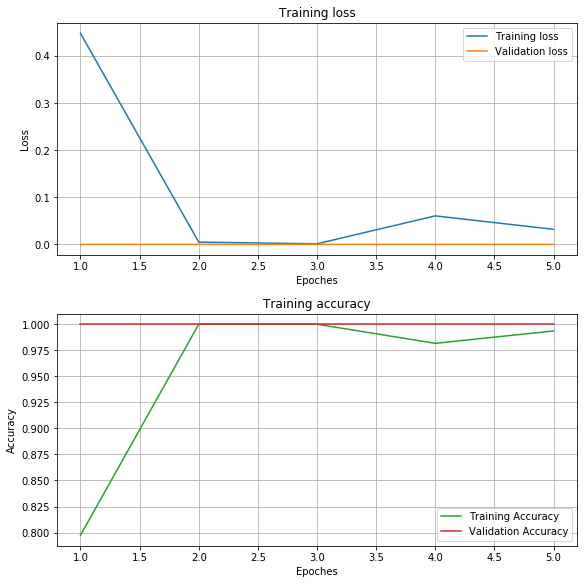

In [6]:

import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(2,constrained_layout=True)
f.set_figheight(8)
f.set_figwidth(8)
epochs = range(1,6)

loss_train = history.history['loss']
acc_train = history.history['accuracy']
loss_val = history.history['val_loss']
acc_val = history.history['val_accuracy']

ax1.set_title('Training loss')
ax1.plot(epochs, loss_train, 'tab:blue',label='Training loss')
ax1.plot(epochs, loss_val, 'tab:orange',label='Validation loss')
ax1.set_xlabel('Epoches')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()



ax2.set_title('Training accuracy')
ax2.plot(epochs, acc_train, 'tab:green',label='Training Accuracy')
ax2.plot(epochs, acc_val, 'tab:red',label='Validation Accuracy')
ax2.set_xlabel('Epoches')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

plt.show()


In [7]:
from keras.models import load_model
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join

new_model = load_model('face03_vgg.h5')

In [8]:
#contains labels of datasets
face_dir=[x for x in os.listdir(validation_data_dir)]

def draw_test(name, pred, im):
    faces = face_dir[pred]
    expand_img=cv2.copyMakeBorder(im,30,30,30,30,cv2.BORDER_CONSTANT)
    cv2.putText(expand_img, faces, (85, 255) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expand_img)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + path_class)
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    

for i in range(0,10):
    input_im = getRandomImage(validation_data_dir)
    input_original=input_im.copy()
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(new_model.predict(input_im))
    
    # Show image with predicted class
    draw_test("Prediction", res, input_original) 
    cv2.waitKey(0)

cv2.destroyAllWindows()

Class - Mom
Class - Mom
Class - Tushar
Class - Mom
Class - Mom
Class - Mom
Class - Mom
Class - Tushar
Class - Mom
Class - Mom
